# GA Data Science Chellenge (V4)

---

# Yu-Ting Shen

---

# Question 1: Data Query

## a.) List the top 5 user_id which had the highest number of CTR filed during in any 7 days window period. (5 points)

Answer:

```SQL
SELECT User_id, MAX(sum_CTR)
FROM (
      SELECT t1.User_id, SUM(t2.CTR) AS sum_CTR
      FROM transactions t1
      JOIN transactions t2
      ON t1.User_id = t2.User_id
      WHERE t2.Timestamp >= t1.Timestamp AND
            t2.Timestamp < DATE(t1.Timestamp, '+7 days')
      GROUP BY t1.User_id, DATE(t1.Timestamp)
      ORDER BY t1.User_id, DATE(t1.Timestamp)
     )
GROUP BY User_id
ORDER BY 2 DESC
LIMIT 5;
```

## b.) List top 5 user_id which had the largest amount of incoming amount over any 30 day period exceeding $1,000,000? (5 points)

Answer:

```SQL
SELECT User_id, MAX(income) 
FROM (
      SELECT t1.User_id, SUM(t2.Amount) as income 
      FROM transactions t1 
      JOIN transactions t2 
      ON t1.User_id = t2.User_id 
      WHERE t2.Timestamp >= t1.Timestamp AND
            t2.Timestamp < DATE(t1.Timestamp, '+30 days') AND
            t2.CashDirection = 'In' 
      GROUP BY 1, DATE(t1.Timestamp) 
      ORDER BY 1, DATE(t1.Timestamp)
     ) 
WHERE income > 1000000 
GROUP BY User_id 
ORDER BY MAX(income) DESC 
LIMIT 5;
```

---

# Question 2: Modeling

## a.) For a not ‘Male’ customer, what is the most important features in predicting likelihood of customer doing cryptocurrency transaction? (5 points)

Answer:

Because all the features are **not in the same scale**, it is very hard to know what is the most important features from the coefficient only. Firstly, we can calculate the **z-score** of each features by taking the ratio of coefficient and standard error.

|Variable       |Coefficient|Standar Error|z-score|
|:--------------|:---------:|:-----------:|:-----:|
|Male           |2.45       |0.12         |20.42  |
|Account Balance|-0.109     |0.041        |-2.66  |
|Age            |-0.0135    |0.00096      |-14.062|
|Age_Sq         |0.0001     |0.000029     |3.45   |
|Investor       |3.21       |0.67         |4.223  |
|Works_at_Y     |-5.12      |0.399        |-12.803|
|Constant       |2.8        |0.584        |4.79   |

All the absolute values of z-score are greater than 2, which means the coefficients are significant different from zero. Therefore, we have to keep all the coefficients.

Since the variables `Investor` and `Works_at_Y` are binary, they have the same scale. Therefore, they can be compared directly. We can see the coefficient of `Works_at_Y` is larger than `Investor`. This means the variable `Works_at_Y` is more important than the `Investor`. However, we cannot compare the coefficients of `Account Balance`, `Age`, `Age_Sq`, and `Works_at_Y` directly because their scale are different.

We can evaluate the effect of logits by using two different values of a variable while fix the other variables. Here are the two different values we use for variables `Account Balance`, `Age`, `Age_Sq`, and `Works_at_Y`.

|Variable       |Value1|Value2|
|:--------------|:----:|:----:|
|Account Balance|1     |$10^9$|
|Age            |1     |100   |
|Works_at_Y     |1     |0     |

The formula of logits is

\begin{equation*}
\ln \frac{p}{1-p} = \sum_{i=0}^{n} \theta_{i} x_{i}
\end{equation*}

And the difference in logits while using two values for one variable is:

\begin{equation*}
\Delta(\ln \frac{p}{1-p}) = \theta_{i} (x_{i, val1} - x_{i, val2})
\end{equation*}


1.) We use `Account Balance` = 1 and $10^9$ and fix the other variables.

\begin{equation*}
\Delta(\ln \frac{p}{1-p})\Big|_{balance} = -0.109 \times (\ln 10^9 - \ln 1) = -2.2588
\end{equation*}

2.) We use `Age` = 1 and 100 and fix the other variables.

\begin{equation*}
\Delta(\ln \frac{p}{1-p})\Big|_{age} = -0.0135 \times (100 - 1) = -1.3365
\end{equation*}

3.) We use `Works_at_Y` = 1 and 0 and fix the other variables.

\begin{equation*}
\Delta(\ln \frac{p}{1-p})\Big|_{Y} = -5.12 \times (1 - 0) = -5.12
\end{equation*}

From above calculations, we see changing the values of `Works_at_Y` causes large effect in the logits. So `Works_at_Y` is the most important feature.

## b.) How do we interpret the difference in probability using cryptocurrency exchange between users of different ages? (5 points)

Answer:

Because the coefficient of the variable `Age` is negative value, which means the older customers the lower probability using cryptocurrency exchange.

---

# Question 3: Data Analysis

## a.) How you would determine if an amount is unusual for a bank's user? (3 points)

Answer: 

We can calculate the IQR of the user's incoming amount. If the incoming amount is greater than **1.5 $\times$ IQR**, then the transaction is suspicious and considerd as unusual.

## b.) A relative of user is defined as someone who shares same phone number. Find the set of relatives for all user_id’s.  (3 points)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Load data
df = pd.read_csv('transaction_data.csv', index_col=0)

# Check data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459995 entries, 0 to 459994
Data columns (total 9 columns):
user_id                       459995 non-null int64
date                          459995 non-null object
trx_type                      459995 non-null object
activity_type                 459995 non-null object
counter_party                 459995 non-null int64
amount                        459995 non-null float64
user_phone_number             459995 non-null object
counter_party_phone_number    10433 non-null object
Y                             459995 non-null int64
dtypes: float64(1), int64(3), object(5)
memory usage: 35.1+ MB


From the above summary, we can see the `counter_party_phone_number` has missing values.

In [3]:
# Show data
df.head()

user_id        date     trx_type activity_type  counter_party  \
0  1001517  1971-06-17          ACH      Incoming        6504238   
1  1001517  1971-12-13          ACH      Incoming        6504238   
2  1001517  1971-09-13          ACH      Outgoing        2501016   
3  1001517  1971-12-13          ACH      Outgoing        7328482   
4  1001517  1971-02-05  Credit_Card      Incoming        6366609   

         amount user_phone_number counter_party_phone_number  Y  
0  28815.726712      409-242-7201                        NaN  0  
1   7578.565233      279-587-7765                        NaN  0  
2  75919.208014      696-429-7698                        NaN  0  
3   3050.378441      261-891-2975                        NaN  0  
4    116.239215      329-791-3754                        NaN  0

In [4]:
def find_relatives(df):
    relatives = {}
    for idx, row in df.iterrows():
        uid = row['user_id']
        number = row['user_phone_number']

        if number in relatives:
            relatives[number].append(uid)
        else:
            relatives[number] = [uid]
    return relatives

results = find_relatives(df[['user_id', 'user_phone_number']])

Now the dictionary `results` contains the key-value pairs.
* key: the phone number
* value: a list of user_id which share the same phone number

For example, let's show 5 phone numbers and the `user_id` share the same number

In [5]:
i = 0
for key, val in results.items():
    if i > 4:
        break
    print('number: ' + key + '\n' + 'user_id:', val, '\n')
    i += 1

number: 409-242-7201
user_id: [1001517, 1190469, 1447636, 2095830, 2233072, 2692753, 3709844, 4404279, 4492440, 4527767, 5975744, 6573585, 6795825, 7336088, 7656125, 7719661, 7971018, 8122253, 8499186, 9587497] 

number: 279-587-7765
user_id: [1001517, 1096821, 1494876, 1655593, 2213934, 2233072, 2297947, 2302817, 2415654, 2466986, 3903970, 6512213, 7183833] 

number: 696-429-7698
user_id: [1001517, 1117432, 2355376, 3252372, 4074368, 5165201, 5429950, 5602669, 6443101, 8043162, 8125816, 8289685, 8654730, 8949093, 9048324, 9842392] 

number: 261-891-2975
user_id: [1001517, 1039572, 1782394, 2045388, 3022056, 3800553, 4245246, 4445856, 5041999, 6911475, 7087909, 7238518, 8220004, 8240340, 9000880, 9090448, 9825611] 

number: 329-791-3754
user_id: [1001517, 1392582, 2361490, 3063959, 3104808, 4594668, 6062401, 6460866, 6602899, 6806768, 7715673, 8437817, 9609792, 9612387] 



## c.) When a transaction happens among relatives, call it circulatory (among relatives) transaction. Create a binary feature if a transaction is circulatory transaction. (4 point)

The `row['user_phone_number']` returns a number and `results[number]` returns a list of `user_id` and they share the same phone number. If `counter_party` is in the list, then this transcation is called circulatory.

In [6]:
df['circulatory'] = df.apply(lambda row: 1 if row['counter_party'] in results[row['user_phone_number']] else 0, axis=1)

df.head()

user_id        date     trx_type activity_type  counter_party  \
0  1001517  1971-06-17          ACH      Incoming        6504238   
1  1001517  1971-12-13          ACH      Incoming        6504238   
2  1001517  1971-09-13          ACH      Outgoing        2501016   
3  1001517  1971-12-13          ACH      Outgoing        7328482   
4  1001517  1971-02-05  Credit_Card      Incoming        6366609   

         amount user_phone_number counter_party_phone_number  Y  circulatory  
0  28815.726712      409-242-7201                        NaN  0            0  
1   7578.565233      279-587-7765                        NaN  0            0  
2  75919.208014      696-429-7698                        NaN  0            0  
3   3050.378441      261-891-2975                        NaN  0            0  
4    116.239215      329-791-3754                        NaN  0            0

## d.) Suppose that you would like to track weekly incoming (from counterparty to user’s account) and outgoing (from user’s account to counterparty’s account) amount (i.e. sum of weekly amount). If this amount is more than $100,000, then an alert should be generated. Create features using these logics. (5 points)

In [7]:
# Convert date to datetime64
df['date'] = pd.to_datetime(df['date'])

# Resample by weekly and sum the amount
df_weekly = df.set_index('date').groupby(['user_id'])['amount'].resample('W').sum().reset_index()

# Select the events which amount > 100,000
df_alert = df_weekly[df_weekly['amount'] > 100000].reset_index()

In [8]:
df_alert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8646 entries, 0 to 8645
Data columns (total 4 columns):
index      8646 non-null int64
user_id    8646 non-null int64
date       8646 non-null datetime64[ns]
amount     8646 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 270.3 KB


In [9]:
# Find the date belong which week of the year
df_alert['week_number'] = df_alert['date'].dt.week

df_alert.head()

index  user_id       date         amount  week_number
0    101  1003411 1971-01-10  170778.213699            1
1    108  1003411 1971-02-28  122195.913984            8
2    112  1003411 1971-03-28  154276.335030           12
3    119  1003411 1971-05-16  106100.056347           19
4    306  1010626 1971-01-31  139526.472116            4

Create a dictionary `week_number` which contains the `user_id` as key and the list of week number as value. The value lists the key has incoming + outgoint amount > $100,000

In [10]:
week_number = {}
for idx, row in df_alert.iterrows():
    uid = row['user_id']
    if uid in week_number:
        week_number[uid].append(row['week_number'])
    else:
        week_number[uid] = [row['week_number']]

In [11]:
# Create a week number features in df
df['week_number'] = df['date'].dt.week

# Create a alert features in df
# If the user's incoming + outgoing amount > $100,000 in a week, then alert is set to 1 otherwise 0
df['alert'] = df.apply(lambda row: 1 if row['user_id'] in week_number and row['week_number'] in week_number[row['user_id']] else 0, axis=1)

In [12]:
# Show the results
df.head()

user_id       date     trx_type activity_type  counter_party        amount  \
0  1001517 1971-06-17          ACH      Incoming        6504238  28815.726712   
1  1001517 1971-12-13          ACH      Incoming        6504238   7578.565233   
2  1001517 1971-09-13          ACH      Outgoing        2501016  75919.208014   
3  1001517 1971-12-13          ACH      Outgoing        7328482   3050.378441   
4  1001517 1971-02-05  Credit_Card      Incoming        6366609    116.239215   

  user_phone_number counter_party_phone_number  Y  circulatory  week_number  \
0      409-242-7201                        NaN  0            0           24   
1      279-587-7765                        NaN  0            0           50   
2      696-429-7698                        NaN  0            0           37   
3      261-891-2975                        NaN  0            0           50   
4      329-791-3754                        NaN  0            0            5   

   alert  
0      0  
1      0  
2      0  
3      0  
4      0

In [13]:
# Check the results, make sure there are events with alert = 1
df[df['alert'] == 1].head()

user_id       date trx_type activity_type  counter_party        amount  \
61  1003411 1971-01-04      ACH      Incoming        8526218  90209.868455   
62  1003411 1971-01-06      ACH      Incoming        9316225  80568.345244   
68  1003411 1971-02-23      ACH      Incoming        7758628  29700.332415   
69  1003411 1971-02-24      ACH      Incoming        8211985   3806.013001   
70  1003411 1971-02-24      ACH      Incoming        9943935  18278.205311   

   user_phone_number counter_party_phone_number  Y  circulatory  week_number  \
61      967-174-5576                        NaN  0            0            1   
62      312-541-8087                        NaN  0            0            1   
68      710-163-4420                        NaN  0            0            8   
69      662-699-9600                        NaN  0            0            8   
70      847-838-8340                        NaN  0            0            8   

    alert  
61      1  
62      1  
68      1  
69      1  
70      1

## e.) Addition to features in d), you would like to use features which tracks weekly number of transaction by “trx_type” and “activity_type”. Create features which uses this logic. (5 points)

In [14]:
df['trx_type'].value_counts()

Debit_Card     205343
ACH            120669
Credit_Card     99678
Check           31944
Cash             2096
Wire              265
Name: trx_type, dtype: int64

In [15]:
df['activity_type'].value_counts()

Outgoing    302532
Incoming    157463
Name: activity_type, dtype: int64

There are 6 categories for `trx_type` and 2 categories for `activity_type`. So 6 x 2 = 12 combinations. Firstly, let's create a new feature `type` which contains 12 combinations and a new features `count` with value 1.

In [16]:
df['type'] = df.apply(lambda row: row['trx_type'] + "_" + row['activity_type'], axis=1)
df['count'] = 1
df.head()

user_id       date     trx_type activity_type  counter_party        amount  \
0  1001517 1971-06-17          ACH      Incoming        6504238  28815.726712   
1  1001517 1971-12-13          ACH      Incoming        6504238   7578.565233   
2  1001517 1971-09-13          ACH      Outgoing        2501016  75919.208014   
3  1001517 1971-12-13          ACH      Outgoing        7328482   3050.378441   
4  1001517 1971-02-05  Credit_Card      Incoming        6366609    116.239215   

  user_phone_number counter_party_phone_number  Y  circulatory  week_number  \
0      409-242-7201                        NaN  0            0           24   
1      279-587-7765                        NaN  0            0           50   
2      696-429-7698                        NaN  0            0           37   
3      261-891-2975                        NaN  0            0           50   
4      329-791-3754                        NaN  0            0            5   

   alert                  type  count  
0      0          ACH_Incoming      1  
1      0          ACH_Incoming      1  
2      0          ACH_Outgoing      1  
3      0          ACH_Outgoing      1  
4      0  Credit_Card_Incoming      1

New we group by `user_id`, `type`, `week_number` and sum over `count`.

In [17]:
df_temp = df.groupby(['user_id', 'type', 'week_number']).sum()
df_temp.head()

counter_party        amount  Y  \
user_id type                 week_number                                   
1001517 ACH_Incoming         24                 6504238  28815.726712  0   
                             50                 6504238   7578.565233  0   
        ACH_Outgoing         37                 2501016  75919.208014  0   
                             50                 7328482   3050.378441  0   
        Credit_Card_Incoming 5                  6366609    116.239215  0   

                                          circulatory  alert  count  
user_id type                 week_number                             
1001517 ACH_Incoming         24                     0      0      1  
                             50                     0      0      1  
        ACH_Outgoing         37                     0      0      1  
                             50                     0      0      1  
        Credit_Card_Incoming 5                      0      0      1

Convert `df_temp` to pivot table

In [18]:
df_temp_pivot = pd.pivot_table(df_temp, index=['user_id', 'week_number'], columns=['type'], values='count')

# Fill NaN using 0
df_temp_pivot = df_temp_pivot.fillna(0)
df_temp_pivot.head()

type                 ACH_Incoming  ACH_Outgoing  Cash_Incoming  Cash_Outgoing  \
user_id week_number                                                             
1001517 5                     0.0           0.0            0.0            0.0   
        10                    0.0           0.0            0.0            0.0   
        14                    0.0           0.0            0.0            0.0   
        18                    0.0           0.0            0.0            0.0   
        19                    0.0           0.0            0.0            0.0   

type                 Check_Incoming  Check_Outgoing  Credit_Card_Incoming  \
user_id week_number                                                         
1001517 5                       0.0             0.0                   1.0   
        10                      0.0             0.0                   1.0   
        14                      0.0             0.0                   1.0   
        18                      0.0             0.0                   1.0   
        19                      0.0             0.0                   1.0   

type                 Credit_Card_Outgoing  Debit_Card_Incoming  \
user_id week_number                                              
1001517 5                             0.0                  0.0   
        10                            0.0                  0.0   
        14                            0.0                  0.0   
        18                            0.0                  0.0   
        19                            0.0                  0.0   

type                 Debit_Card_Outgoing  Wire_Incoming  Wire_Outgoing  
user_id week_number                                                     
1001517 5                            0.0            0.0            0.0  
        10                           0.0            0.0            0.0  
        14                           0.0            0.0            0.0  
        18                           0.0            0.0            0.0  
        19                           0.0            0.0            0.0

Now we can combine the `df` and `df_temp_pivot` tables to produce the final table which will be used for building predictive model.

In [19]:
df_merged = df.merge(df_temp_pivot, on=['user_id', 'week_number'])

df_merged.head()

user_id       date     trx_type activity_type  counter_party        amount  \
0  1001517 1971-06-17          ACH      Incoming        6504238  28815.726712   
1  1001517 1971-06-16  Credit_Card      Incoming        7167533    414.361427   
2  1001517 1971-12-13          ACH      Incoming        6504238   7578.565233   
3  1001517 1971-12-13          ACH      Outgoing        7328482   3050.378441   
4  1001517 1971-09-13          ACH      Outgoing        2501016  75919.208014   

  user_phone_number counter_party_phone_number  Y  circulatory      ...        \
0      409-242-7201                        NaN  0            0      ...         
1      278-173-1195                        NaN  0            0      ...         
2      279-587-7765                        NaN  0            0      ...         
3      261-891-2975                        NaN  0            0      ...         
4      696-429-7698                        NaN  0            0      ...         

   Cash_Incoming  Cash_Outgoing Check_Incoming  Check_Outgoing  \
0            0.0            0.0            0.0             0.0   
1            0.0            0.0            0.0             0.0   
2            0.0            0.0            0.0             0.0   
3            0.0            0.0            0.0             0.0   
4            0.0            0.0            0.0             0.0   

   Credit_Card_Incoming  Credit_Card_Outgoing  Debit_Card_Incoming  \
0                   1.0                   0.0                  0.0   
1                   1.0                   0.0                  0.0   
2                   0.0                   0.0                  0.0   
3                   0.0                   0.0                  0.0   
4                   0.0                   0.0                  0.0   

   Debit_Card_Outgoing  Wire_Incoming  Wire_Outgoing  
0                  0.0            0.0            0.0  
1                  0.0            0.0            0.0  
2                  0.0            0.0            0.0  
3                  0.0            0.0            0.0  
4                  0.0            0.0            0.0  

[5 rows x 26 columns]

## f.) Using the features as created in part (c), (d) and (e), build a statistical machine learning model to detect the suspicious money laundering cases. (To build a model, data (features, and Y) can be aggregated at [“user_id”, “date”] level. ) Report model performance using a relevant metric (and why you would choose this metric?) (8+2 points)

In [20]:
# List of features
df_merged.columns

Index(['user_id', 'date', 'trx_type', 'activity_type', 'counter_party',
       'amount', 'user_phone_number', 'counter_party_phone_number', 'Y',
       'circulatory', 'week_number', 'alert', 'type', 'count', 'ACH_Incoming',
       'ACH_Outgoing', 'Cash_Incoming', 'Cash_Outgoing', 'Check_Incoming',
       'Check_Outgoing', 'Credit_Card_Incoming', 'Credit_Card_Outgoing',
       'Debit_Card_Incoming', 'Debit_Card_Outgoing', 'Wire_Incoming',
       'Wire_Outgoing'],
      dtype='object')

There are many features but we only need part of them to build predictive model.

In [21]:
columns = df_merged.columns.difference(['trx_type', 'activity_type', 'type', 'counter_party', 'user_phone_number', 'counter_party_phone_number', 'week_number', 'count'])
print(columns)

Index(['ACH_Incoming', 'ACH_Outgoing', 'Cash_Incoming', 'Cash_Outgoing',
       'Check_Incoming', 'Check_Outgoing', 'Credit_Card_Incoming',
       'Credit_Card_Outgoing', 'Debit_Card_Incoming', 'Debit_Card_Outgoing',
       'Wire_Incoming', 'Wire_Outgoing', 'Y', 'alert', 'amount', 'circulatory',
       'date', 'user_id'],
      dtype='object')


In [22]:
# The dataframe for building model
df_model = df_merged[columns]

# Aggreate by user_id and date
df_model = df_model.groupby(['user_id', 'date']).sum()

df_model.head()

ACH_Incoming  ACH_Outgoing  Cash_Incoming  Cash_Outgoing  \
user_id date                                                                   
1001517 1971-02-05           0.0           0.0            0.0            0.0   
        1971-03-11           0.0           0.0            0.0            0.0   
        1971-04-06           0.0           0.0            0.0            0.0   
        1971-05-05           0.0           0.0            0.0            0.0   
        1971-05-10           0.0           0.0            0.0            0.0   

                    Check_Incoming  Check_Outgoing  Credit_Card_Incoming  \
user_id date                                                               
1001517 1971-02-05             0.0             0.0                   1.0   
        1971-03-11             0.0             0.0                   1.0   
        1971-04-06             0.0             0.0                   1.0   
        1971-05-05             0.0             0.0                   1.0   
        1971-05-10             0.0             0.0                   1.0   

                    Credit_Card_Outgoing  Debit_Card_Incoming  \
user_id date                                                    
1001517 1971-02-05                   0.0                  0.0   
        1971-03-11                   0.0                  0.0   
        1971-04-06                   0.0                  0.0   
        1971-05-05                   0.0                  0.0   
        1971-05-10                   0.0                  0.0   

                    Debit_Card_Outgoing  Wire_Incoming  Wire_Outgoing  Y  \
user_id date                                                               
1001517 1971-02-05                  0.0            0.0            0.0  0   
        1971-03-11                  0.0            0.0            0.0  0   
        1971-04-06                  0.0            0.0            0.0  0   
        1971-05-05                  0.0            0.0            0.0  0   
        1971-05-10                  0.0            0.0            0.0  0   

                    alert      amount  circulatory  
user_id date                                        
1001517 1971-02-05      0  116.239215            0  
        1971-03-11      0  608.308096            0  
        1971-04-06      0  391.071690            0  
        1971-05-05      0  302.650516            0  
        1971-05-10      0   34.903677            0

In [24]:
selected_features = df_model.columns.difference(['user_id', 'date', 'Y'])
print(selected_features)

X = df_model[selected_features].values
y = df_model['Y'].values

Index(['ACH_Incoming', 'ACH_Outgoing', 'Cash_Incoming', 'Cash_Outgoing',
       'Check_Incoming', 'Check_Outgoing', 'Credit_Card_Incoming',
       'Credit_Card_Outgoing', 'Debit_Card_Incoming', 'Debit_Card_Outgoing',
       'Wire_Incoming', 'Wire_Outgoing', 'alert', 'amount', 'circulatory'],
      dtype='object')


In [25]:
# Check the labels
df_model['Y'].value_counts()

0    350150
1       719
Name: Y, dtype: int64

#### Build model

Because this is imbalance data, we need to use SMOTE to handel the inputs.

In [26]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y) # Use SMOTE to resample inputs

#### train test split

In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=0)

#### Define metric

In [28]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def get_performance_metrics(y_train, p_train_pred, y_test, p_test_pred, threshold=0.5):
    metric_names = ['AUC', 'Accuracy', 'Precision', 'Recall', 'f1-score']
    
    metric_values_train = [roc_auc_score(y_train, p_train_pred),
                           accuracy_score(y_train, p_train_pred > threshold),
                           precision_score(y_train, p_train_pred > threshold),
                           recall_score(y_train, p_train_pred > threshold),
                           f1_score(y_train, p_train_pred > threshold)]
    
    metric_values_test = [roc_auc_score(y_test, p_test_pred),
                          accuracy_score(y_test, p_test_pred > threshold),
                          precision_score(y_test, p_test_pred > threshold),
                          recall_score(y_test, p_test_pred > threshold),
                          f1_score(y_test, p_test_pred > threshold)]
    
    all_metrics = pd.DataFrame({'metrics': metric_names,
                                'train': metric_values_train,
                                'test': metric_values_test},
                                columns=['metrics', 'train', 'test'])

    all_metrics.set_index('metrics')
    print(all_metrics)


#### Define ploting functions

In [29]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_train, p_train_pred, y_test, p_test_pred):
    roc_auc_train = roc_auc_score(y_train, p_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, p_train_pred)
    
    roc_auc_test = roc_auc_score(y_test, p_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, p_test_pred)
    
    lw=2
    plt.figure()
    plt.plot(fpr_train, tpr_train, color='green', linewidth=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange', linewidth=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', linewidth=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc='lower right')
    plt.show()

In [30]:
def plot_feature_importance(model):
    df_feature_importance = pd.DataFrame()
    df_feature_importance['feature'] = selected_features
    df_feature_importance['importance'] = model.feature_importances_
    df_feature_importance.sort_values('importance', inplace=True)
    
    ax = df_feature_importance.plot(kind='barh', figsize=(20, 10))
    t = np.arange(len(df_feature_importance['feature']))
    ax.set_yticks(t)
    ax.set_yticklabels(df_feature_importance['feature'])
    plt.show()


#### Define model and performance function

In [31]:
def train_test_model(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    
    y_train_pred = clf.predict(X_train)
    y_train_prob = clf.predict_proba(X_train)[:, 1]
    
    y_test_pred = clf.predict(X_test)
    y_test_prob = clf.predict_proba(X_test)[:, 1]
    
    get_performance_metrics(y_train, y_train_prob, y_test, y_test_prob)
    plot_roc_curve(y_train, y_train_prob, y_test, y_test_prob)

#### Run model

#### Logistic Regression

/usr/local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


     metrics     train      test
0        AUC  0.873596  0.874638
1   Accuracy  0.499555  0.501161
2  Precision  0.499540  0.501135
3     Recall  1.000000  1.000000
4   f1-score  0.666258  0.667675


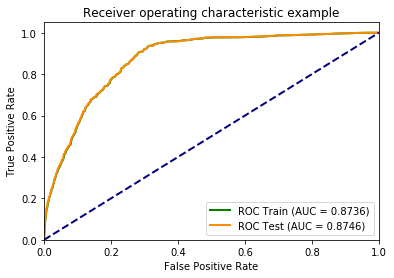

In [32]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1.0, penalty='l2')
train_test_model(lr, X_train, y_train, X_test, y_test)

In [34]:
coef_values = zip(selected_features, lr.coef_.flatten()) # connect feature names and values
df_coeffs = pd.DataFrame(list(coef_values))
df_coeffs.columns = ['Feature', 'Coefficient']
df_coeffs.sort_values(by='Coefficient', ascending=False, inplace=True)
df_coeffs

Feature   Coefficient
13                amount  2.071239e-05
9    Debit_Card_Outgoing  8.868644e-06
1           ACH_Outgoing  7.173269e-06
12                 alert  1.560496e-06
6   Credit_Card_Incoming  5.746693e-07
4         Check_Incoming  5.298029e-07
0           ACH_Incoming  4.789250e-07
8    Debit_Card_Incoming  2.443133e-07
7   Credit_Card_Outgoing  1.471014e-07
11         Wire_Outgoing  5.436046e-08
10         Wire_Incoming  7.984206e-09
14           circulatory  0.000000e+00
2          Cash_Incoming -1.298619e-08
3          Cash_Outgoing -3.769388e-08
5         Check_Outgoing -6.198035e-08

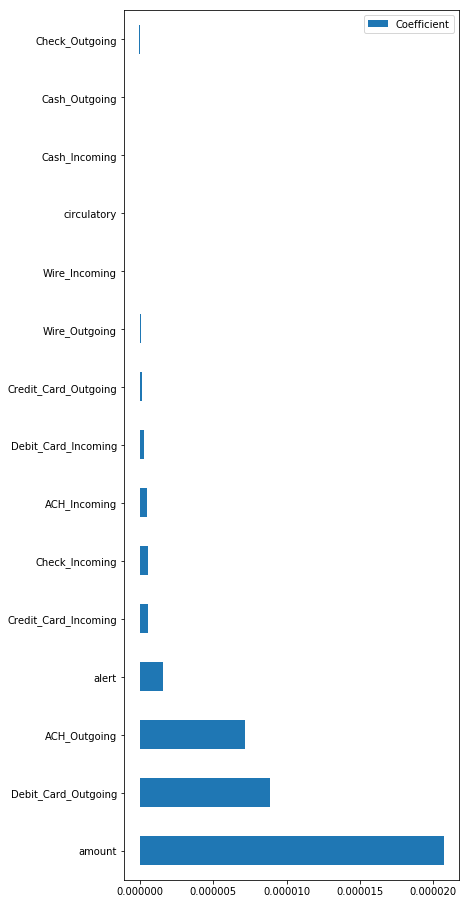

In [35]:
ax = df_coeffs.plot(kind='barh')
ax.set_yticks( np.arange(X.shape[1]) )
ax.set_yticklabels(df_coeffs['Feature'])
plt.gcf().set_size_inches(6, 16)
plt.show()

#### Random Forest

     metrics     train      test
0        AUC  0.998604  0.998498
1   Accuracy  0.986228  0.985720
2  Precision  0.981253  0.980774
3     Recall  0.991371  0.990929
4   f1-score  0.986286  0.985825


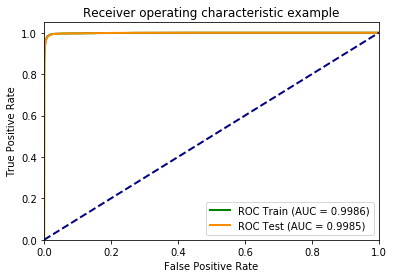

In [36]:
from sklearn.ensemble import RandomForestClassifier
paras_rf = {'n_estimators': 50,
            'max_features': 'auto',
            'criterion': 'gini',
            'max_depth': 20,
            'min_samples_split': 2,
            'min_samples_leaf': 20,
            'random_state': 0,
            'n_jobs': -1}
rf = RandomForestClassifier(**paras_rf)

train_test_model(rf, X_train, y_train, X_test, y_test)

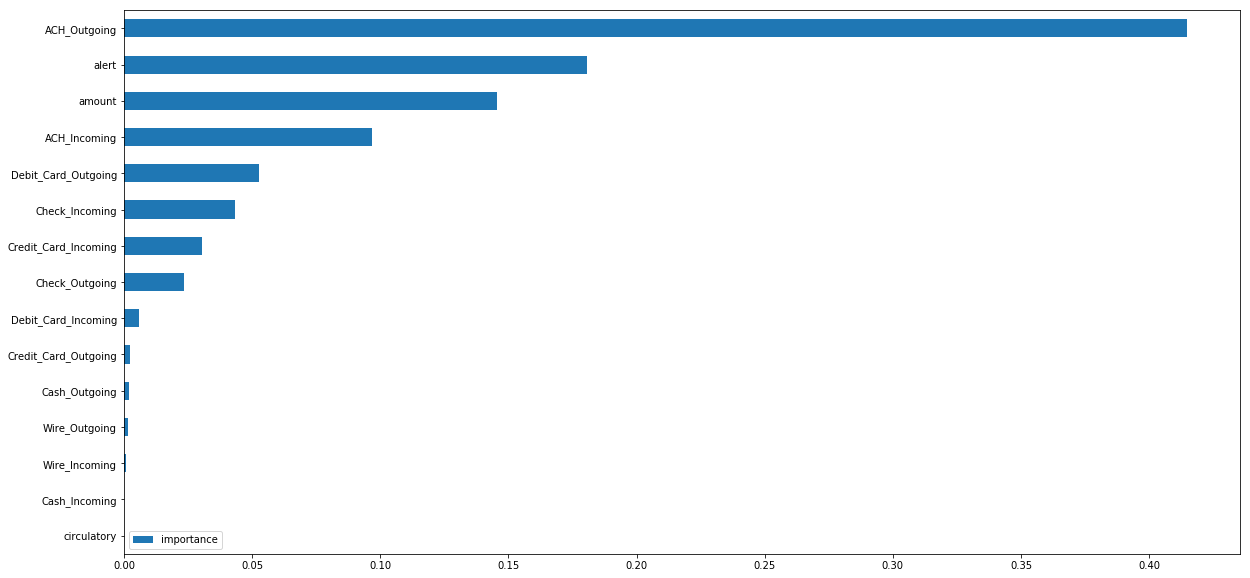

In [37]:
plot_feature_importance(rf)

#### Gradient Boosting Trees

     metrics     train      test
0        AUC  0.999109  0.999073
1   Accuracy  0.992046  0.991447
2  Precision  0.992113  0.991601
3     Recall  0.991963  0.991328
4   f1-score  0.992038  0.991464


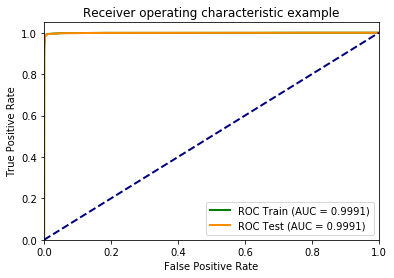

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
params_gbt = {'n_estimators': 50,
              'max_depth': 5,
              'learning_rate': 0.2,
              'random_state': 42}

gbt = GradientBoostingClassifier(**params_gbt)

train_test_model(gbt, X_train, y_train, X_test, y_test)

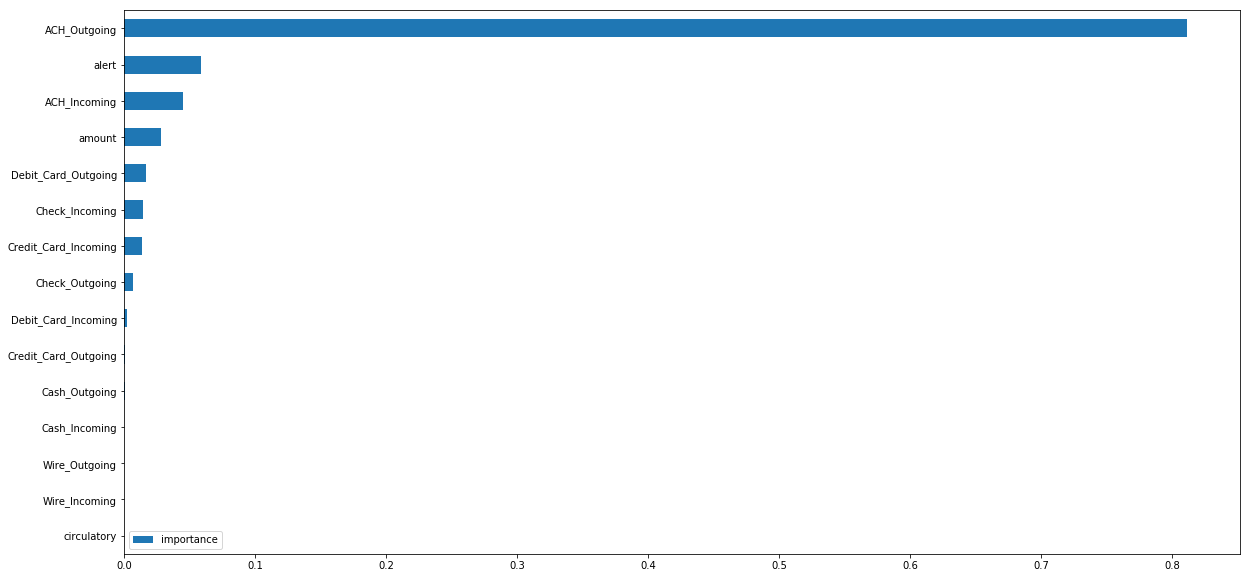

In [39]:
plot_feature_importance(gbt)

#### Model performance

* In the ROC curve we look at:
  * TPR = TP / (TP+FN)
  * FPR = FP / (FP+TN)

* Precision and recall are:
  * Precision = TP/(TP+FP)
  * Recall = TP / (TP+FN)
  
Because TPR is exactly Recall, we can compare FPR and Precision. Since this data is highly imbalance, the TN is ver large causing FPR is very small. Therefore, the Precision is more important in this study. Following are the metrics using 3 different model, we can see the random forest and gradient boosting trees have better performance than logistic regression. For this case, the precision of logistic regression is only about half of tree-based models.
  
Using logistic regression:

|metrics  |train   |test    |
|:-------:|:------:|:------:|
|AUC      |0.873596|0.874638|
|Accuracy |0.499555|0.501161|
|Precision|0.499540|0.501135|
|Recall   |1.000000|1.000000|
|f1-score |0.666258|0.667675|

Using random forest

|metrics  |train   |test    |
|:-------:|:------:|:------:|
|AUC      |0.998604|0.998498|
|Accuracy |0.986228|0.985720|
|Precision|0.981253|0.980774|
|Recall   |0.991371|0.990929|
|f1-score |0.986286|0.985825|

Using gradient boosting trees

|metrics  |train   |test    |
|:-------:|:------:|:------:|
|AUC      |0.999109|0.999073|
|Accuracy |0.992046|0.991447|
|Precision|0.992113|0.991601|
|Recall   |0.991963|0.991328|
|f1-score |0.992038|0.991464|

